In [1]:
from azureml.core import Workspace, Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime
import pickle
from tbats import TBATS
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm_notebook

from itertools import product
matplotlib.rc_file_defaults()
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

## L1-osasto - aikasarjamallien vertailu

In [2]:
train_test_day = pd.Timestamp('2019-01-01')
start = pd.Timestamp('2017-01-01T00')
end = pd.Timestamp('2019-12-31T00')

In [3]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'
workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset_ward = Dataset.get_by_name(workspace, name='uranus27_2')
features_ward = ['henkilotunnus', 'alkuhetki', 'loppuhetki', 'vo_toimipiste_nimi', 'pot_eala_selite', 
       'paadg_oire_selite', 'mista_lah_tuli_koodi', 'mista_lah_tuli_nimi', 'mista_tuli_koodi', 
       'mista_tuli_selite', 'jatkoh_laitos_nimi', 'jatkoh_toimipiste_nimi', 'jh_koodi', 'jh_selite', 
       'osastohoito_numero', 'shjakso_numero']
ward = dataset_ward.to_pandas_dataframe()[features_ward]
ward.replace("", float("NaN"), inplace=True)
ward.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
ward.drop_duplicates(subset='osastohoito_numero', inplace=True)
ward = ward[(ward.alkuhetki >= start) & (ward.alkuhetki < end)]
ward_train = ward[ward.alkuhetki < train_test_day]
ward_test = ward[ward.alkuhetki >= train_test_day]
pd.set_option('display.max_columns', None)
ward_train = ward_train.sort_values(by='alkuhetki')

In [4]:
ward_train['alkuhetki'] = pd.to_datetime(ward_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train['loppuhetki'] = pd.to_datetime(ward_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train = ward_train[ward_train['alkuhetki'] <= ward_train['loppuhetki']]
ward_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_train['alkuhetki'], right = ward_train['loppuhetki'], closed='neither')
ward_train['palveluaika'] = ((ward_train['loppuhetki'] - ward_train['alkuhetki']).astype('timedelta64[s]') / 3600)
print('Keskiarvo:', ward_train.palveluaika.mean())

Keskiarvo: 60.41710412232989


In [5]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = ((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600)

### Aikasarja päivätasolla

In [6]:
aika = start
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(730)]})
timestamp_day = [aika + timedelta(days=x) for x in range(729)]
ward_train_day = pd.DataFrame(data={'time':timestamp_day})
ward_train_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
ward_train_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).contains(b) for b in ward_train['alkuhetki']]).sum()
ward_train_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_day['timespan']).overlaps(b) for b in ward_train['aikaväli']]).sum()
ward_train_day.set_index('time', inplace=True)
ward_train_day.head()

,timespan,arrivals,patient_count
time,,,
2017-01-01,"[2017-01-01, 2017-01-02)",5,5
2017-01-02,"[2017-01-02, 2017-01-03)",8,13
2017-01-03,"[2017-01-03, 2017-01-04)",3,16
2017-01-04,"[2017-01-04, 2017-01-05)",6,20
2017-01-05,"[2017-01-05, 2017-01-06)",10,21


In [7]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(152)]})
timestamp_day = [aika + timedelta(days=x) for x in range(151)]
ward_test_day = pd.DataFrame(data={'time':timestamp_day})
ward_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
ward_test_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).contains(b) for b in ward_test['alkuhetki']]).sum()
ward_test_day['departments'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).contains(b) for b in ward_test['loppuhetki']]).sum()
ward_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_day['timespan']).overlaps(b) for b in ward_test['aikaväli']]).sum()
ward_test_day.set_index('time', inplace=True)

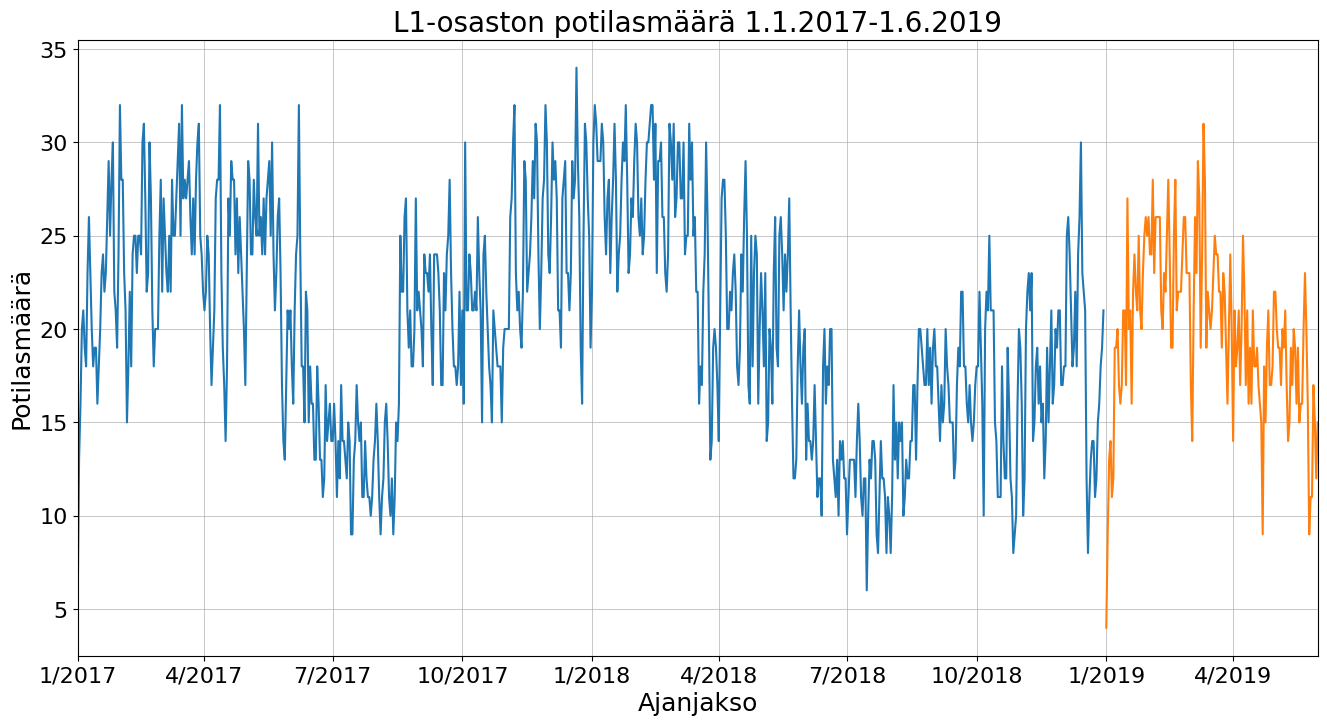

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(ward_train_day.index, ward_train_day['patient_count'])
plt.plot(ward_test_day.index, ward_test_day['patient_count'])
plt.rcParams.update({'font.size': 16})
plt.title('L1-osaston potilasmäärä 1.1.2017-1.6.2019', fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Potilasmäärä', fontsize=18)
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'),
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'], fontsize=16)
plt.grid(linewidth=0.5)
plt.margins(x=0)
plt.show()

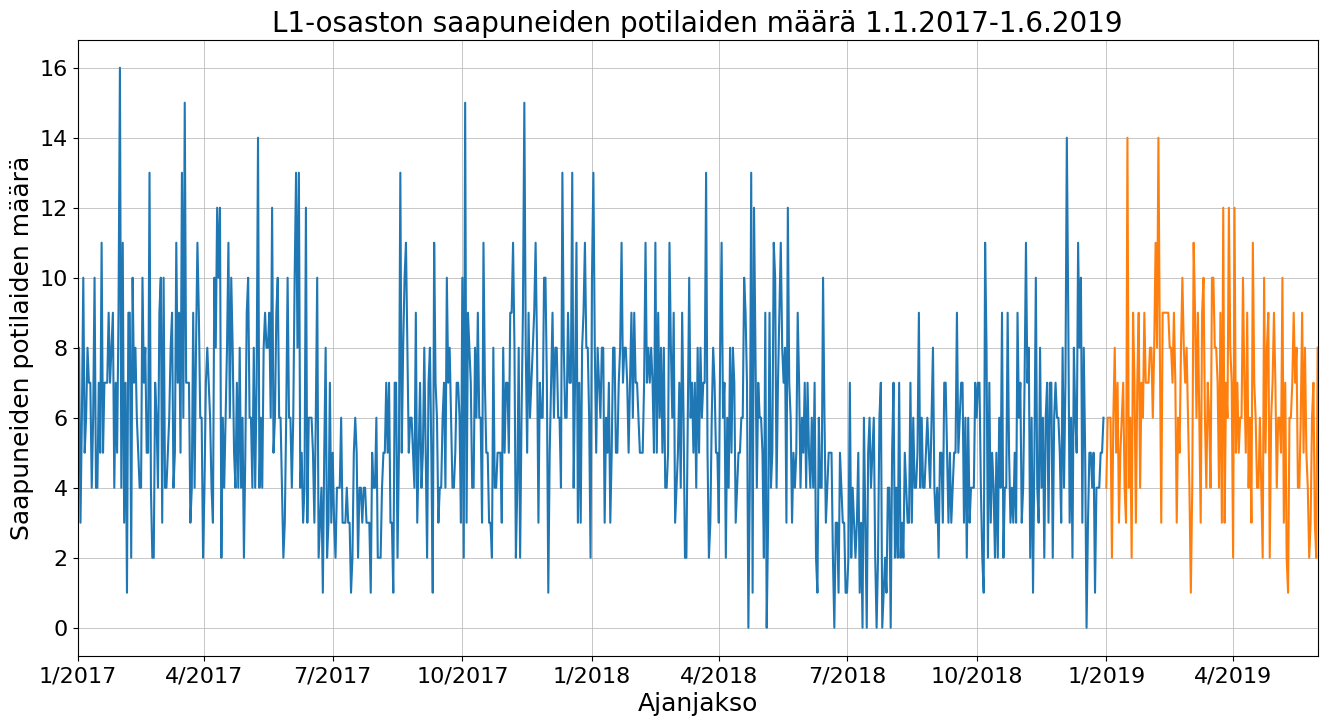

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(ward_train_day.index, ward_train_day['arrivals'])
plt.plot(ward_test_day.index, ward_test_day['arrivals'])
plt.rcParams.update({'font.size': 16})
plt.title('L1-osaston saapuneiden potilaiden määrä 1.1.2017-1.6.2019', fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Saapuneiden potilaiden määrä', fontsize=18)
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'], fontsize=16)
plt.grid(linewidth=0.5)
plt.margins(x=0)
plt.show()

## Kausittaisen vaihtelun analysointi

#### Saapuvat potilaat

In [10]:
aika = start
full_span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(882)]})
full_timestamp_day = [aika + timedelta(days=x) for x in range(881)]
ward_day = pd.DataFrame(data={'time':full_timestamp_day})
ward_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = full_span_day['time'][0:-1], right = full_span_day['time'][1:], closed='left')
ward_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(ward_day['timespan']).contains(b) for b in ward['alkuhetki']]).sum()
ward_day['weekday'] = ward_day['time'].dt.weekday
ward_day['month'] = ward_day['time'].dt.month
ward_day.head()

week_avearr = [ward_day[ward_day['weekday'] == d]['arrivals'].mean() for d in range(7)]
month_avearr = [ward_day[ward_day['month'] == d + 1]['arrivals'].mean() for d in range(12)]

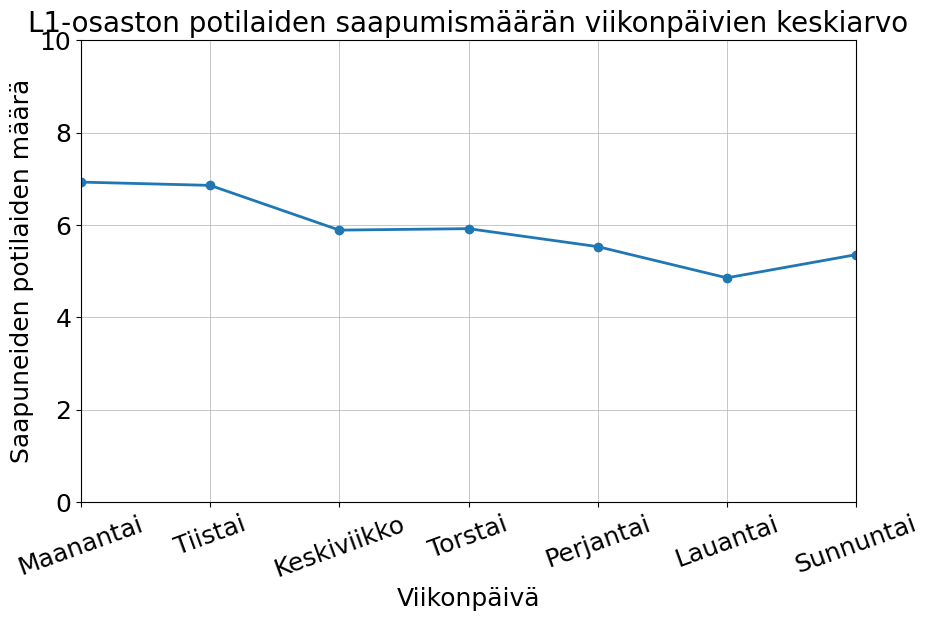

In [11]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 18})
plt.plot(range(7), week_avearr, 'o-', linewidth=2)
plt.title('L1-osaston potilaiden saapumismäärän viikonpäivien keskiarvo', fontsize=20)
plt.xticks(range(7), labels=['Maanantai', 'Tiistai', 'Keskiviikko', 'Torstai', 'Perjantai', 'Lauantai', 'Sunnuntai'], rotation=20)
plt.xlabel('Viikonpäivä', fontsize=18)
plt.ylabel('Saapuneiden potilaiden määrä', fontsize=18)
plt.margins(x=0)
plt.ylim([0, 10])
plt.grid(linewidth=0.5)
plt.show()

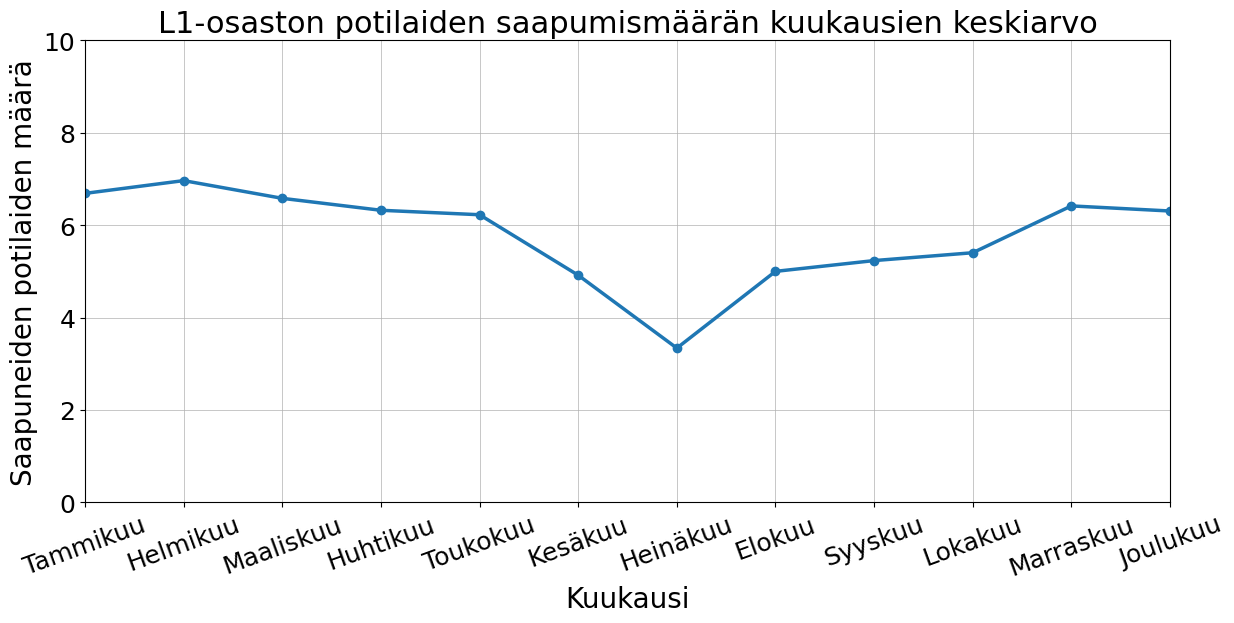

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(range(12), month_avearr, 'o-', linewidth=2.5)
plt.title('L1-osaston potilaiden saapumismäärän kuukausien keskiarvo', fontsize=22)
plt.xticks(range(12), labels=['Tammikuu', 'Helmikuu', 'Maaliskuu', 'Huhtikuu', 'Toukokuu', 'Kesäkuu', 'Heinäkuu', 'Elokuu', 'Syyskuu', 'Lokakuu', 'Marraskuu', 'Joulukuu'], rotation=20)
plt.xlabel('Kuukausi', fontsize=20)
plt.ylabel('Saapuneiden potilaiden määrä', fontsize=20)
plt.margins(x=0)
plt.ylim([0, 10])
plt.grid(linewidth=0.5)
plt.show()


## Palveluajan analysointi

In [13]:
ward['weekday'] = ward.alkuhetki.dt.weekday
ward['month'] = ward.alkuhetki.dt.month
ward['palveluaika'] = ((ward['loppuhetki'] - ward['alkuhetki']).astype('timedelta64[s]') / 3600)
tammi = ward[ward.month == 0].groupby(by='weekday').mean()
helmi = ward[ward.month == 1].groupby(by='weekday').mean()
maalis = ward[ward.month == 2].groupby(by='weekday').mean()
huhti = ward[ward.month == 3].groupby(by='weekday').mean()
touko = ward[ward.month == 4].groupby(by='weekday').mean()
kesa = ward[ward.month == 5].groupby(by='weekday').mean()
heina = ward[ward.month == 6].groupby(by='weekday').mean()
elo = ward[ward.month == 7].groupby(by='weekday').mean()
syys = ward[ward.month == 8].groupby(by='weekday').mean()
loka = ward[ward.month == 9].groupby(by='weekday').mean()
marras = ward[ward.month == 10].groupby(by='weekday').mean()
joulu = ward[ward.month == 11].groupby(by='weekday').mean()

palveluajat = [tammi.palveluaika, helmi.palveluaika, maalis.palveluaika, huhti.palveluaika, touko.palveluaika, kesa.palveluaika, 
    heina.palveluaika, elo.palveluaika, syys.palveluaika, loka.palveluaika, marras.palveluaika, joulu.palveluaika]
ward_palveluajat = pd.DataFrame(data={'ave_palveluaika':palveluajat})


## Aikasarjan stationaarisuus

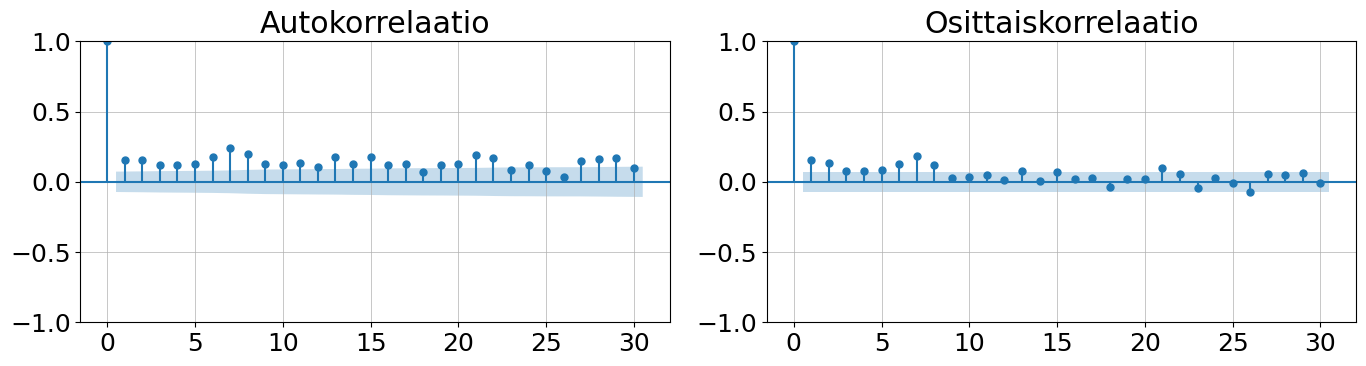

In [14]:
def correlations(y, lags):
    fig = plt.figure(figsize=(14, 4))
    layout = (1,2)
    acf_ax = plt.subplot2grid(layout, (0,0))
    pacf_ax = plt.subplot2grid(layout, (0,1))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, title='Autokorrelaatio')
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, title='Osittaiskorrelaatio')
    acf_ax.grid(linewidth=0.5)
    pacf_ax.grid(linewidth=0.5)
    plt.tight_layout()

correlations(ward_train_day.arrivals, lags=30)

#### Ensimmäinen erotteluprosessi

Dickey-Fuller p-value: 1.5624538423397943e-05
Dickey-Fuller p-value after 1. differencing: 1.7839540845607813e-16
KPSS p-value: 0.01
KPSS p-value after 1. differencing: 0.1


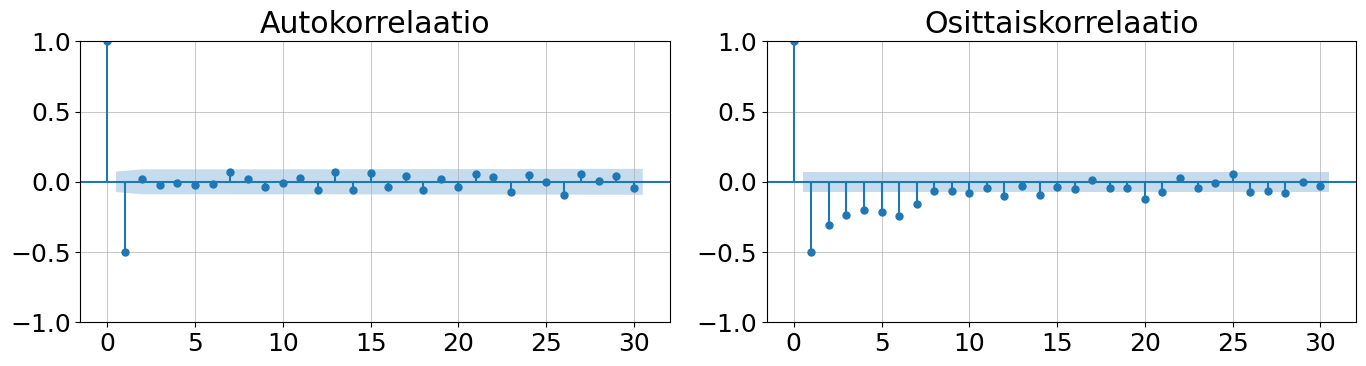

In [15]:
data_diff = ward_train_day.arrivals - ward_train_day.arrivals.shift(1)
print('Dickey-Fuller p-value:', adfuller(ward_train_day.arrivals)[1])
print('Dickey-Fuller p-value after 1. differencing:', adfuller(data_diff[1:])[1])
print('KPSS p-value:', kpss(ward_train_day.arrivals)[1])
print('KPSS p-value after 1. differencing:', kpss(data_diff[1:])[1])

correlations(data_diff[1:], lags=30)

#### Ensimmäinen kausittainen erotteluprosessi

Dickey-Fuller p-value: 1.5624538423397943e-05
Dickey-Fuller p-value after 1. seasonal differencing: 9.347378719698624e-14
KPSS p-value: 0.01
KPSS p-value after 1. seasonal differencing: 0.1


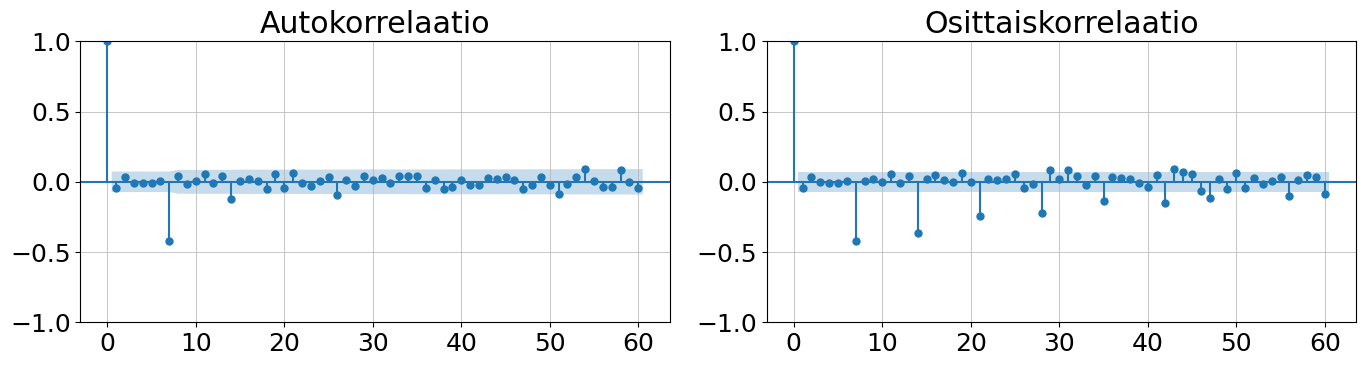

In [16]:
data_diff_seas = ward_train_day.arrivals - ward_train_day.arrivals.shift(7)
print('Dickey-Fuller p-value:', adfuller(ward_train_day.arrivals)[1])
print('Dickey-Fuller p-value after 1. seasonal differencing:', adfuller(data_diff_seas[7:])[1])
print('KPSS p-value:', kpss(ward_train_day.arrivals)[1])
print('KPSS p-value after 1. seasonal differencing:', kpss(data_diff_seas[7:])[1])

correlations(data_diff_seas[7:], lags=60)

### ARIMA

In [17]:
def choose_ARIMA(parameters_list, d):
    results = []
    best_aic = float('inf')
    
    for par in tqdm_notebook(parameters_list):
        model = ARIMA(ward_train_day.arrivals, order=(par[0], d, par[1])).fit() 
            
        aic_score = model.aic
        if aic_score < best_aic:
            best_model = model
            best_aic = aic_score
            best_param = par
        results.append([par, model.aic])
        
    table = pd.DataFrame(results)
    table.columns = ['parameters', 'aic']
    table = table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return table


ps = range(0, 2)
d = 1
qs = range(0, 7)

parameters_list = list(product(ps, qs))
#results = optim_ARIMA(parameters_list, d)
#p, q = results.parameters[0]
#arima_model = ARIMA(ward_train_day.arrivals, order=(p, d, q)).fit() 

arima_model = pickle.load(open('ARIMA_L1_2017-2019_final.pkl', 'rb'))
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:               arrivals   No. Observations:                  729
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1736.902
Date:                Sat, 15 Apr 2023   AIC                           3477.803
Time:                        13:09:17   BIC                           3486.984
Sample:                    01-01-2017   HQIC                          3481.345
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9353      0.015    -62.316      0.000      -0.965      -0.906
sigma2         6.8962      0.328     21.049      0.000       6.254       7.538
Ljung-Box (L1) (Q):                   0.02   Jarque-

### SARIMA

In [18]:
def choose_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')
    
    for par in tqdm_notebook(parameters_list):
        model = sm.tsa.statespace.SARIMAX(ward_train_day.arrivals, order=(par[0], d, par[1]), seasonal_order=(par[2], D, par[3], s)).fit()
            
        aic_score = model.aic
        if aic_score < best_aic:
            best_model = model
            best_aic = aic_score
            best_param = par
        results.append([par, model.aic])
        
    table = pd.DataFrame(results)
    table.columns = ['parameters', 'aic']
    table = table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return table

ps = range(0, 2)
d = 1
qs = range(0, 7)
Ps = range(0, 3)
D = 1
Qs = range(0, 7) 
s = 7

parameters_list = list(product(ps, qs, Ps, Qs))

#result_table = choose_SARIMA(parameters_list, d, D, s)
#p, q, P, Q = result_table.parameters[0]
#sarima_model = sm.tsa.statespace.SARIMAX(ward_train_day.arrivals, order=(p, d, q),
#                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

sarima_model = pickle.load(open('SARIMA_L1_2017-2019_final.pkl', 'rb'))
print(sarima_model.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                     arrivals   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2, 3, 4], 7)   Log Likelihood               -1705.095
Date:                                      Sat, 15 Apr 2023   AIC                           3424.190
Time:                                              13:09:18   BIC                           3456.254
Sample:                                          01-01-2017   HQIC                          3436.568
                                               - 12-30-2018                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9265      0.016  

In [19]:
#pickle.dump(arima_model, open('ARIMA_L1_2017-2019_final.pkl', 'wb'))
#pickle.dump(sarima_model, open('SARIMA_L1_2017-2019_final.pkl', 'wb'))

### TBATS

In [20]:
#tbats = TBATS(seasonal_periods=[7, 365])
#tbats = tbats.fit(ward_train_day.arrivals)
tbats = pickle.load(open('tbats_L1_2017-2019_final.pkl', 'rb'))
print(tbats.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [2 1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.051582
Seasonal Parameters (Gamma): [5.32035104e-09 8.26262635e-09 9.09854782e-10 5.25900078e-09]
AR coefficients []
MA coefficients []
Seed vector [ 5.32874467 -0.22271202 -0.37662783  0.79402918  0.37758015  1.00177266
  0.45946503]

AIC 6183.244844


## Ennusteet

In [21]:
new_index = pd.date_range("2019-01-01", "2019-06-01")
additive = pd.DataFrame(np.nan, index=new_index[:-1], columns=ward_train_day.columns)
additive.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
additive['ennuste_ARIMA'] = arima_model.predict(start=730, end=881, dynamic=True)
additive['ennuste_SARIMA'] = sarima_model.predict(start=730, end=881, dynamic=True)
ts_model = pickle.load(open('tbats_L1_2017-2019_final.pkl', 'rb'))
additive['ennuste_TBATS'] =  ts_model.forecast(steps=151)

ward_train_day = pd.concat([ward_train_day, additive])

In [22]:
import matplotlib
matplotlib.rc_file_defaults()

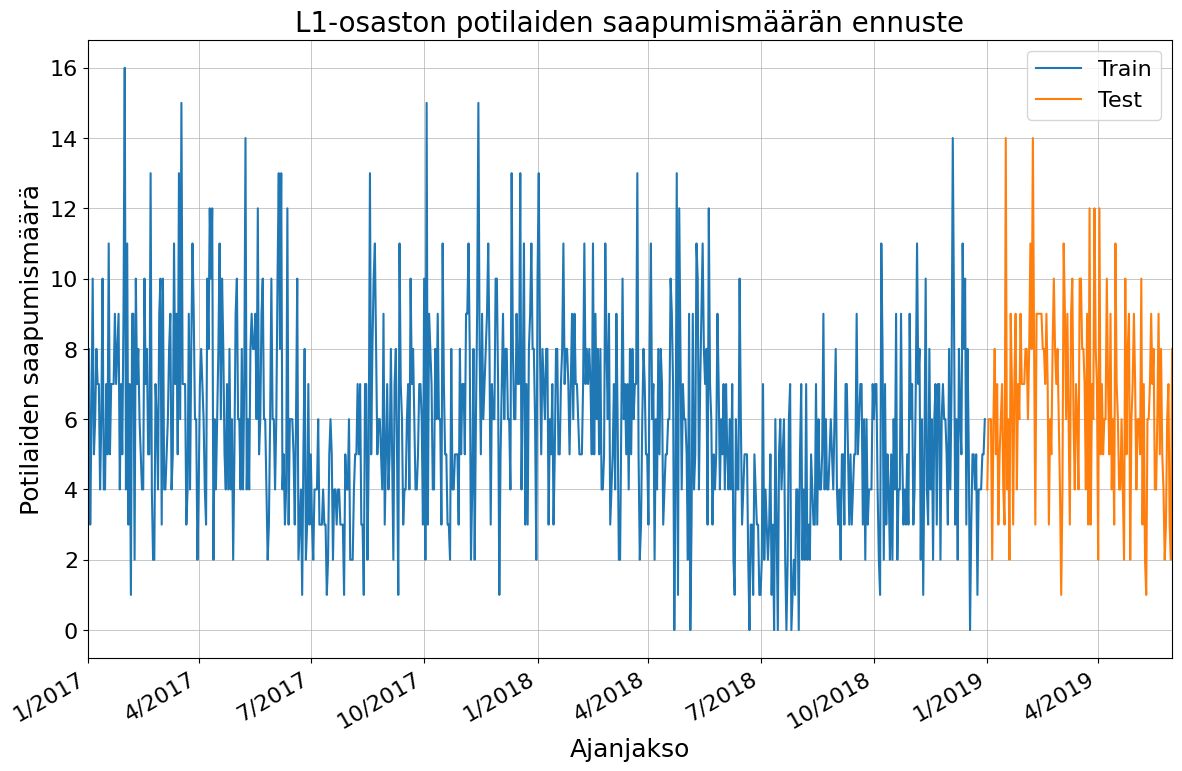

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ward_train_day.arrivals, ls='-', label='Train')
ax.plot(ward_test_day.arrivals, ls='-', label='Test')
plt.rcParams.update({'font.size': 16})
plt.title("L1-osaston potilaiden saapumismäärän ennuste", fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

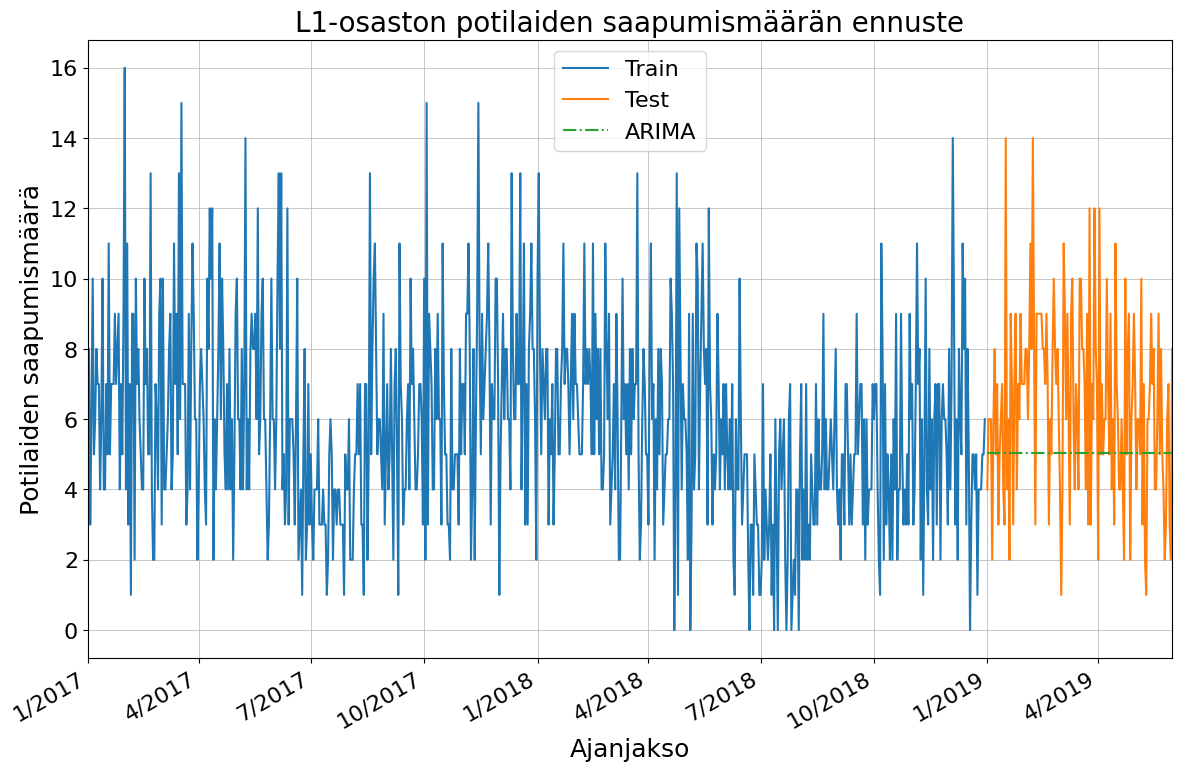

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ward_train_day.arrivals, ls='-', label='Train')
ax.plot(ward_test_day.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_ARIMA, ls='-.', label='ARIMA')
plt.rcParams.update({'font.size': 16})
plt.title("L1-osaston potilaiden saapumismäärän ennuste", fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

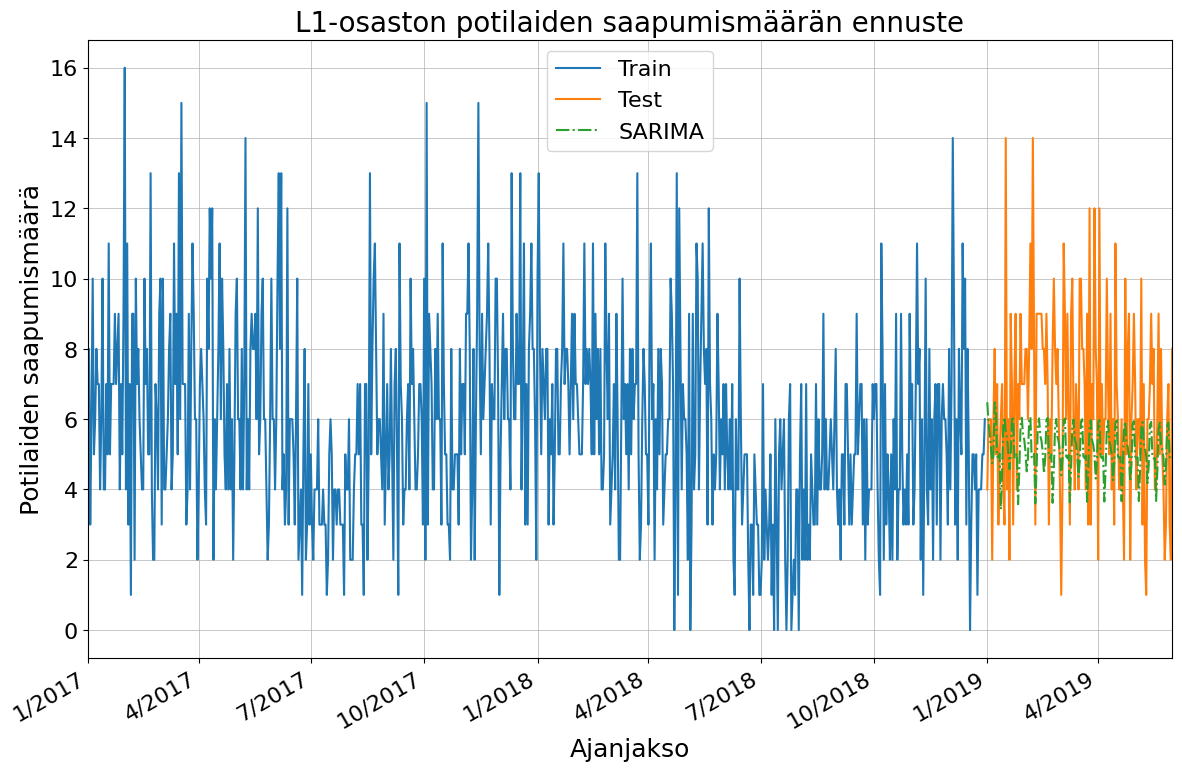

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ward_train_day.arrivals, ls='-', label='Train')
ax.plot(ward_test_day.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_SARIMA, ls='-.', label='SARIMA')
plt.rcParams.update({'font.size': 16})
plt.title("L1-osaston potilaiden saapumismäärän ennuste", fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

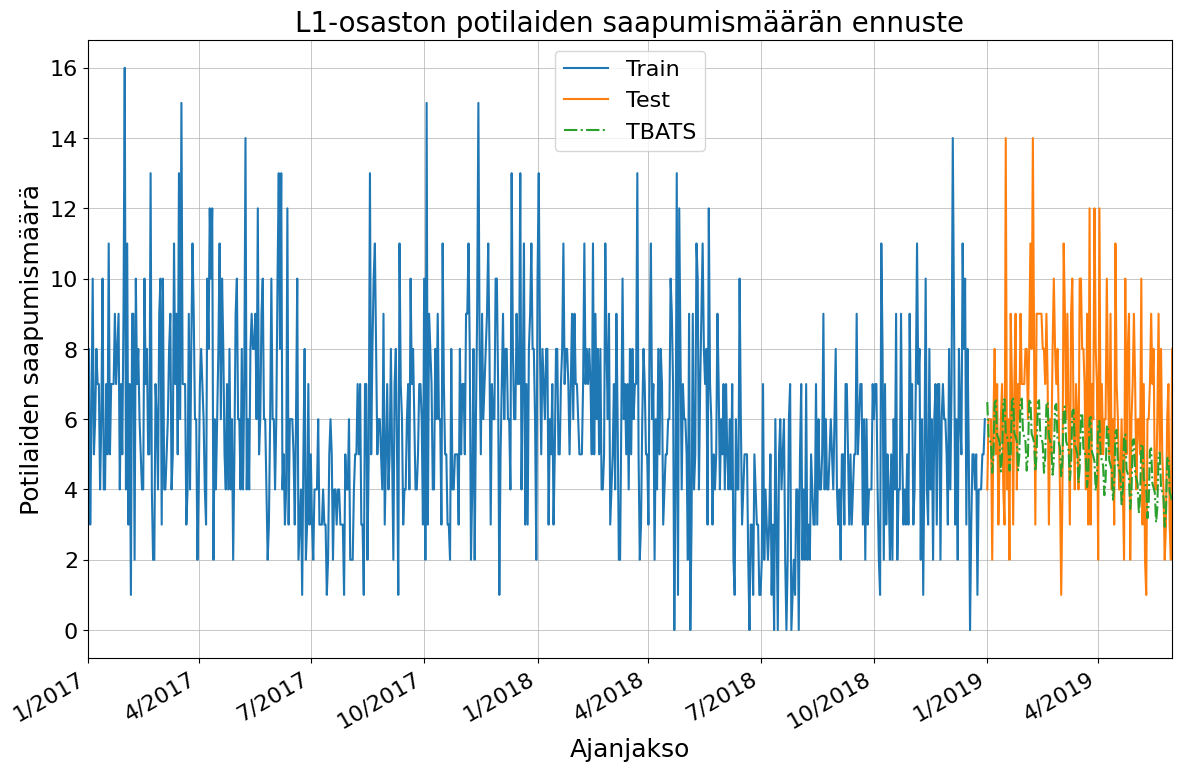

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ward_train_day.arrivals, ls='-', label='Train')
ax.plot(ward_test_day.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_TBATS, ls='-.', label='TBATS')
plt.rcParams.update({'font.size': 16})
plt.title("L1-osaston potilaiden saapumismäärän ennuste", fontsize=20)
plt.xlabel('Ajanjakso', fontsize=18)
plt.ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.tight_layout()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()


## Vuosiennuste

In [27]:
aika = train_test_day
span_day = pd.DataFrame(data={'time':[aika + timedelta(days=x) for x in range(365)]})
timestamp_day = [aika + timedelta(days=x) for x in range(364)]
year_test_day = pd.DataFrame(data={'time':timestamp_day})
year_test_day['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
year_test_day['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_day['timespan']).contains(b) for b in ward_test['alkuhetki']]).sum()
year_test_day['departments'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_day['timespan']).contains(b) for b in ward_test['loppuhetki']]).sum()
year_test_day['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_day['timespan']).overlaps(b) for b in ward_test['aikaväli']]).sum()
year_test_day.set_index('time', inplace=True)
year_test_day.head()

,timespan,arrivals,departments,patient_count
time,,,,
2019-01-01,"[2019-01-01, 2019-01-02)",4,1,4
2019-01-02,"[2019-01-02, 2019-01-03)",6,2,9
2019-01-03,"[2019-01-03, 2019-01-04)",6,5,13
2019-01-04,"[2019-01-04, 2019-01-05)",6,5,14
2019-01-05,"[2019-01-05, 2019-01-06)",2,5,11


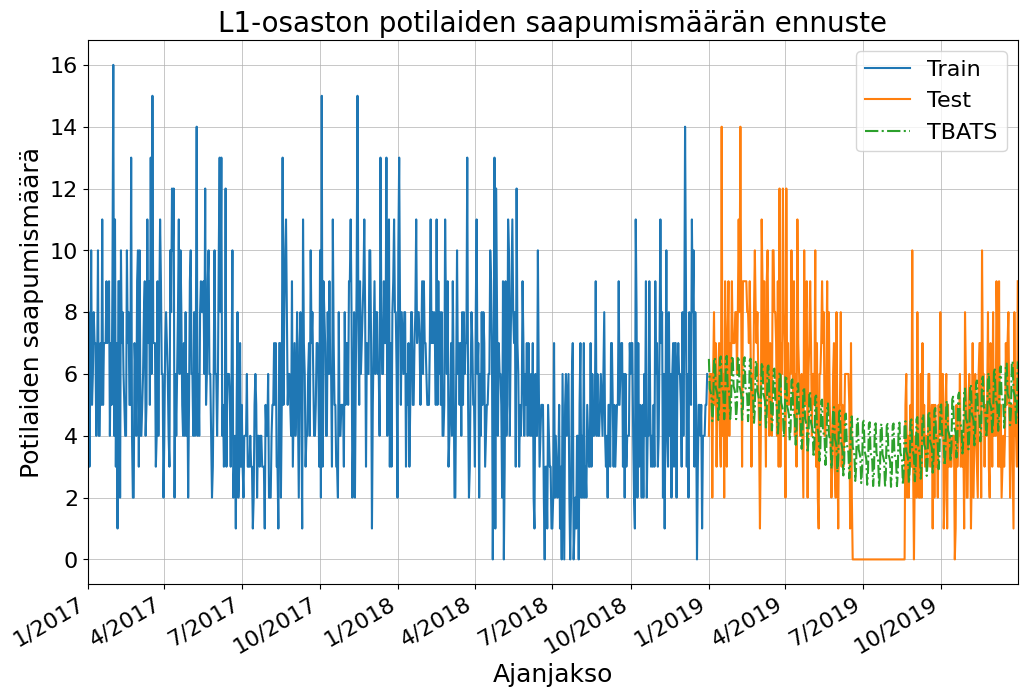

In [28]:
new_index = pd.date_range("2019-01-01", "2019-12-31")
year_pred = pd.DataFrame(np.nan, index=new_index[:-1], columns=ward_train_day.columns)
year_pred.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
year_pred['TBATS'] = ts_model.forecast(steps=364)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams.update({'font.size': 16})
ax.plot(ward_train_day.arrivals, ls='-', label='Train')
ax.plot(year_test_day.arrivals, ls='-', label='Test')
ax.plot(year_pred.TBATS, ls='-.', label='TBATS')
ax.set_title('L1-osaston potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01'), 
    pd.Timestamp('2019-07-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-12-31')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', 
    '7/2018', '10/2018', '1/2019', '4/2019', '7/2019', '10/2019', '1/2020'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))

## Tulokset
### Viiden kuukauden ennuste

In [30]:
y_pred = additive.ennuste_ARIMA
mape_arima = mean_absolute_percentage_error(ward_test_day.arrivals, y_pred)
mae_arima = mean_absolute_error(ward_test_day.arrivals, y_pred)
mse_arima = mean_squared_error(ward_test_day.arrivals, y_pred)
rmse_arima = np.sqrt(mse_arima)
print('MAPE ARIMA:', mape_arima)
print('MAE ARIMA:', mae_arima)
print('MSE ARIMA:', mse_arima)
print('RMSE ARIMA:', rmse_arima)
print()

y_pred = additive.ennuste_SARIMA
mape_sarima = mean_absolute_percentage_error(ward_test_day.arrivals, y_pred)
mae_sarima = mean_absolute_error(ward_test_day.arrivals, y_pred)
mse_sarima = mean_squared_error(ward_test_day.arrivals, y_pred)
rmse_sarima = np.sqrt(mse_sarima)
print('MAPE SARIMA:', mape_sarima)
print('MAE SARIMA:', mae_sarima)
print('MSE SARIMA:', mse_sarima)
print('RMSE SARIMA:', rmse_sarima)
print()

y_pred = additive.ennuste_TBATS
mape_tbats = mean_absolute_percentage_error(ward_test_day.arrivals, y_pred)
mae_tbats = mean_absolute_error(ward_test_day.arrivals, y_pred)
mse_tbats = mean_squared_error(ward_test_day.arrivals, y_pred)
rmse_tbats = np.sqrt(mse_tbats)
print('MAPE TBATS:', mape_tbats)
print('MAE TBATS:', mae_tbats)
print('MSE TBATS:', mse_tbats)
print('RMSE TBATS:', rmse_tbats)

MAPE ARIMA: 44.14303618973594
MAE ARIMA: 2.407397659555548
MSE ARIMA: 8.700120592153054
RMSE ARIMA: 2.9495966829641396

MAPE SARIMA: 42.77475841853793
MAE SARIMA: 2.3195692673250683
MSE SARIMA: 8.035018513564887
RMSE SARIMA: 2.8346108222408395

MAPE TBATS: 41.007950605875095
MAE TBATS: 2.3056720809900124
MSE TBATS: 7.974252128034285
RMSE TBATS: 2.8238718327916876


### 42 päivän ennuste

In [31]:
y_pred = additive.ennuste_ARIMA[:42]
mape_arima = mean_absolute_percentage_error(ward_test_day.arrivals[:42], y_pred)
mae_arima = mean_absolute_error(ward_test_day.arrivals[:42], y_pred)
mse_arima = mean_squared_error(ward_test_day.arrivals[:42], y_pred)
rmse_arima = np.sqrt(mse_arima)
print('MAPE ARIMA:', mape_arima)
print('MAE ARIMA:', mae_arima)
print('MSE ARIMA:', mse_arima)
print('RMSE ARIMA:', rmse_arima)
print()

y_pred = additive.ennuste_SARIMA[:42]
mape_sarima = mean_absolute_percentage_error(ward_test_day.arrivals[:42], y_pred)
mae_sarima = mean_absolute_error(ward_test_day.arrivals[:42], y_pred)
mse_sarima = mean_squared_error(ward_test_day.arrivals[:42], y_pred)
rmse_sarima = np.sqrt(mse_sarima)
print('MAPE SARIMA:', mape_sarima)
print('MAE SARIMA:', mae_sarima)
print('MSE SARIMA:', mse_sarima)
print('RMSE SARIMA:', rmse_sarima)
print()

y_pred = additive.ennuste_TBATS[:42]
mape_tbats = mean_absolute_percentage_error(ward_test_day.arrivals[:42], y_pred)
mae_tbats = mean_absolute_error(ward_test_day.arrivals[:42], y_pred)
mse_tbats = mean_squared_error(ward_test_day.arrivals[:42], y_pred)
rmse_tbats = np.sqrt(mse_tbats)
print('MAPE TBATS:', mape_tbats)
print('MAE TBATS:', mae_tbats)
print('MSE TBATS:', mse_tbats)
print('RMSE TBATS:', rmse_tbats)

MAPE ARIMA: 39.466394691442666
MAE ARIMA: 2.456112685836467
MSE ARIMA: 9.61240065318664
RMSE ARIMA: 3.100387177948367

MAPE SARIMA: 40.14871392884745
MAE SARIMA: 2.4505059237102893
MSE SARIMA: 9.365051298265513
RMSE SARIMA: 3.0602371310513687

MAPE TBATS: 39.3716696036807
MAE TBATS: 2.2885724943783052
MSE TBATS: 8.282710522833163
RMSE TBATS: 2.877969861348997


### 30 päivän ennuste

In [32]:
y_pred = additive.ennuste_ARIMA[:30]
mape_arima = mean_absolute_percentage_error(ward_test_day.arrivals[:30], y_pred)
mae_arima = mean_absolute_error(ward_test_day.arrivals[:30], y_pred)
mse_arima = mean_squared_error(ward_test_day.arrivals[:30], y_pred)
rmse_arima = np.sqrt(mse_arima)
print('MAPE ARIMA:', mape_arima)
print('MAE ARIMA:', mae_arima)
print('MSE ARIMA:', mse_arima)
print('RMSE ARIMA:', rmse_arima)
print()

y_pred = additive.ennuste_SARIMA[:30]
mape_sarima = mean_absolute_percentage_error(ward_test_day.arrivals[:30], y_pred)
mae_sarima = mean_absolute_error(ward_test_day.arrivals[:30], y_pred)
mse_sarima = mean_squared_error(ward_test_day.arrivals[:30], y_pred)
rmse_sarima = np.sqrt(mse_sarima)
print('MAPE SARIMA:', mape_sarima)
print('MAE SARIMA:', mae_sarima)
print('MSE SARIMA:', mse_sarima)
print('RMSE SARIMA:', rmse_sarima)
print()

y_pred = additive.ennuste_TBATS[:30]
mape_tbats = mean_absolute_percentage_error(ward_test_day.arrivals[:30], y_pred)
mae_tbats = mean_absolute_error(ward_test_day.arrivals[:30], y_pred)
mse_tbats = mean_squared_error(ward_test_day.arrivals[:30], y_pred)
rmse_tbats = np.sqrt(mse_tbats)
print('MAPE TBATS:', mape_tbats)
print('MAE TBATS:', mae_tbats)
print('MSE TBATS:', mse_tbats)
print('RMSE TBATS:', rmse_tbats)

MAPE ARIMA: 38.502727273405455
MAE ARIMA: 2.0208404860019504
MSE ARIMA: 6.811621608581861
RMSE ARIMA: 2.6099083525254025

MAPE SARIMA: 41.66431105329492
MAE SARIMA: 2.1171498080953097
MSE SARIMA: 6.97111182279076
RMSE SARIMA: 2.6402863145482462

MAPE TBATS: 41.07689604974821
MAE TBATS: 1.9967700016517775
MSE TBATS: 6.442995596071276
RMSE TBATS: 2.538305654579699
